In [1]:
import Pkg
Pkg.add("LightGraphs")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


# Doubly Connected Components

In [6]:
using LightGraphs

function merge_sets_union_find(set_of_sets::Set{Set{T}}) where T
    # Step 1: Map each element to a unique subset
    element_to_set = Dict{T, Set{T}}()
    for subset in set_of_sets
        for elem in subset
            element_to_set[elem] = subset
        end
    end

    # Step 2: Union subsets with overlapping elements
    for subset in set_of_sets
        # Find all subsets connected to the current subset
        merged_subset = Set(subset)
        for elem in subset
            merged_subset = union(merged_subset, element_to_set[elem])
        end

        # Update the mapping for all elements in the merged subset
        for elem in merged_subset
            element_to_set[elem] = merged_subset
        end
    end

    # Step 3: Collect unique subsets
    return Set(values(element_to_set))
end


merge_sets_union_find (generic function with 1 method)

In [7]:
function add_strays(graph::AbstractGraph, sets_of_nodes::Set{Set{Int}})
    # Collect all nodes in the given sets
    nodes_in_sets = reduce(union, sets_of_nodes, init=Set{Int}())
    
    # Get all nodes in the graph
    all_nodes = Set(1:nv(graph))
    
    # Find nodes not in any of the sets (strays)
    stray_nodes = setdiff(all_nodes, nodes_in_sets)
    
    # Add each stray node as its own set
    for stray in stray_nodes
        push!(sets_of_nodes, Set([stray]))
    end
    
    return sets_of_nodes
end

add_strays (generic function with 1 method)

In [8]:
function doubly_connected_components(graph)
    cycles = Set(Set(x) for x in filter(x->length(x)>2, simplecycles(DiGraph(graph))))
    doubly_connected_components_no_strays = merge_sets_union_find(cycles)
    return add_strays(graph, doubly_connected_components_no_strays)
end

doubly_connected_components (generic function with 1 method)

In [9]:
# Create a graph
graph = SimpleGraph(7)
add_edge!(graph, 1, 2)
add_edge!(graph, 2, 4)
add_edge!(graph, 4, 3)
add_edge!(graph, 3, 1)
add_edge!(graph, 2, 3)

add_edge!(graph, 4, 5)
add_edge!(graph, 5, 6)
add_edge!(graph, 6, 7)


doubly_connected_components(graph)


Set{Set{Int64}} with 4 elements:
  Set([5])
  Set([7])
  Set([4, 2, 3, 1])
  Set([6])

# Solver

In [79]:
using JuMP
using Gurobi
using LightGraphs  # For connectivity checks in the callback
using CSV, DataFrames, LinearAlgebra  # For distance calculations

# Load the data from CSV files
data_center_cost = CSV.read("data/data_center_cost.csv", DataFrame)
facility_locations = CSV.read("data/facility_locations.csv", DataFrame)
people = CSV.read("data/people.csv", DataFrame)

# Constants
n_facilities = 25
n_customers = 297
k = 10
w = 10000  # Cost per unit length of wire
F = 40000  # Cost per unit length of fiber optic cable

# Extract facility setup costs
C = data_center_cost.cost  # Facility setup costs

# Extract coordinates for facilities and customers
facility_coords = [facility_locations.x facility_locations.y]
customer_coords = [people.x people.y]

297×2 Matrix{Float64}:
  93.8045  14.4532
 100.45     4.7353
  95.6608   6.30443
  88.4726   2.89257
  86.1005   1.3171
  87.71     0.0183008
  89.3777  -0.631223
  99.3471  10.7486
  77.3258   3.59022
  91.5108  -2.64824
  95.3526  16.2417
  83.888   -0.737108
  87.7327   0.608581
   ⋮       
  23.0043  79.6782
  16.2533  78.445
  15.3479  73.5572
  13.5277  61.205
  11.5204  63.8452
  24.2711  82.6944
  25.5274  79.7146
  28.4144  80.5234
  12.3452  61.6171
  30.945   81.6866
  20.4845  76.2468
  14.7245  64.042

In [80]:
# Compute distances dynamically
function euclidean_distance(coord1, coord2)
    return norm(coord1 - coord2)
end

# Facility-to-customer distances
d = [euclidean_distance(facility_coords[i, :], customer_coords[j, :]) for i in 1:n_facilities, j in 1:n_customers]

# Facility-to-facility distances
D = [i == i_prime ? 0 : euclidean_distance(facility_coords[i, :], facility_coords[i_prime, :]) for i in 1:n_facilities, i_prime in 1:n_facilities]

# Initialize model
model = direct_model(Gurobi.Optimizer())

# Decision variables
@variable(model, x[1:n_facilities], Bin)  # Facility setup decision
@variable(model, 0 <= y[1:n_facilities, 1:n_customers] <= 1)  # Fractional connections
@variable(model, z[i=1:n_facilities, i_prime=i+1:n_facilities], Bin)  # Facility-to-facility connections only for i < i_prime

# Objective function: Minimize total costs
@objective(model, Min, sum(C[i] * x[i] for i in 1:n_facilities) +
                          sum(w * d[i, j] * y[i, j] for i in 1:n_facilities, j in 1:n_customers) +
                          sum(F * D[i, i_prime] * z[i, i_prime] for i in 1:n_facilities, i_prime in i+1:n_facilities))

# Constraints
# 1. Customer demand satisfaction
@constraint(model, [j=1:n_customers], sum(y[i, j] for i in 1:n_facilities) == 1)

# 2. Wires only for open facilities
@constraint(model, [i=1:n_facilities, j=1:n_customers], y[i, j] <= x[i])

# 3. Fiber optic cables only for open facilities
@constraint(model, [i=1:n_facilities, i_prime=i+1:n_facilities], z[i, i_prime] <= x[i])
@constraint(model, [i=1:n_facilities, i_prime=i+1:n_facilities], z[i, i_prime] <= x[i_prime])

# 4. Limit the number of selected facilities
@constraint(model, sum(x[i] for i in 1:n_facilities) <= k)
@constraint(model, sum(x[i] for i in 1:n_facilities) >= 3)

cb_calls = Cint[]
# 5. Connectivity callback to enforce at least 2 cables between partitions
function connectivity_callback(cb_data, cb_where::Cint)

    # You can reference variables outside the function as normal
    push!(cb_calls, cb_where)
    # You can select where the callback is run
    if cb_where != GRB_CB_MIPSOL
        return
    end
    

    println("WOOOOOOOOOOOOOO!!!")

    Gurobi.load_callback_variable_primal(cb_data, cb_where)

    println("HELLO 1!!!")

    # Get the values of the x and z variables
    x_vals = callback_value.(Ref(cb_data), x)
    z_vals = callback_value.(Ref(cb_data), z)
    z_vals = Dict((i, i_prime) => z_vals[i, i_prime] for i in 1:n_facilities for i_prime in i+1:n_facilities)

    println("HELLO 2!!!")

    # Identify selected facilities
    selected_facilities = [i for i in 1:n_facilities if x_vals[i] > 0.5]

    num_selected = length(selected_facilities)

    println("HELLO 3!!!")
    println("X: ", x_vals)
    println("Z: ", z_vals)
    println("SELECTED: ", selected_facilities)


    # Skip if fewer than 2 facilities are selected
    if num_selected <= 1
        return
    end

    # Translation dictionary for facility indices
    actual_to_simple = Dict(selected_facilities[i] => i for i in 1:num_selected)
    simple_to_actual = Dict(i => selected_facilities[i] for i in 1:num_selected)

    println("HELLO 4!!!")

    # Check for connectivity using a graph representation
    g = SimpleGraph(num_selected)
    for i in 1:num_selected
        for i_prime in i+1:num_selected
            if z_vals[(simple_to_actual[i], simple_to_actual[i_prime])] > 0.5
                add_edge!(g, i, i_prime)
            end
        end
    end

    println("HELLO 5!!!")

    # Find doubly connected components in the graph
    components = doubly_connected_components(g)
    println("COMPONENTS: ", components)

    # For each disconnected subset, enforce the connectivity constraint
    for component in components
        complement = setdiff(1:num_selected, component)
        if !isempty(component) && !isempty(complement)
            println("ADDING CONSTRAINT FOR COMPONENT: ", component)
            println([[min(simple_to_actual[i], simple_to_actual[i_prime]), max(simple_to_actual[i], simple_to_actual[i_prime])] for i in component, i_prime in complement])
            con = @build_constraint(sum(z[min(simple_to_actual[i], simple_to_actual[i_prime]), max(simple_to_actual[i], simple_to_actual[i_prime])] for i in component, i_prime in complement) >= 2)
            MOI.submit(model, MOI.LazyConstraint(cb_data), con)
        end
    end
end

# You _must_ set this parameter if using lazy constraints.
MOI.set(model, MOI.RawOptimizerAttribute("LazyConstraints"), 1)
MOI.set(model, Gurobi.CallbackFunction(), connectivity_callback)
optimize!(model)

# Output results
println("Optimal Objective Value: ", objective_value(model))
println("Facilities to open: ", [i for i in 1:n_facilities if value(x[i]) > 0.5])
println("Customer-facility connections (y):")
for i in 1:n_facilities, j in 1:n_customers
    if value(y[i, j]) > 1e-6  # Small threshold to filter non-zero values
        println("  Customer $j -> Facility $i: ", value(y[i, j]))
    end
end
println("Facility-facility connections (z):")
for i in 1:n_facilities, i_prime in i+1:n_facilities
    if value(z[i, i_prime]) > 0.5
        println("  Facility $i <-> Facility $i_prime")
    end
end


Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-18
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 8324 rows, 7750 columns and 23525 nonzeros
Model fingerprint: 0xc197f679
Variable types: 7425 continuous, 325 integer (325 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+03, 5e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Presolve time: 0.02s
Presolved: 8324 rows, 7750 columns, 23525 nonzeros
Variable types: 7425 continuous, 325 integer (325 binary)
WOOOOOOOOOOOOOO!!!
HELLO 1!!!
HELLO 2!!!
HELLO 3!!!
X: [-0.0, -0.0, 1.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, 1.0, -0.0, 1.0, -0.0, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, -0.0, -0.0]
Z: Dict((11, 17) => -0.0, (8, 15) => -0.0, (7, 

# Display results

In [87]:
using Plots

function plot_facilities_and_customers(facility_coords, customer_coords, x, y, z)
    # Extract selected facilities based on x values
    selected_indices = [i for i in 1:length(x) if value(x[i]) > 0.5]
    
    # Create the plot
    p = scatter(customer_coords[:, 1], customer_coords[:, 2], 
                color=:orange, label="Customers", grid=true, legend=false, aspect_ratio=:equal)  # Enable grid with `grid=true`
    scatter!(p, facility_coords[:, 1], facility_coords[:, 2], 
             color=:gray, label="Candidate Facilities")
    scatter!(p, facility_coords[selected_indices, 1], facility_coords[selected_indices, 2], 
             color=:green, label="Selected Facilities")

    # Add customer-to-facility connections (dotted orange lines)
    for i in 1:size(y, 1)  # Facilities
        for j in 1:size(y, 2)  # Customers
            if value(y[i, j]) > 1e-6
                plot!(p, [facility_coords[i, 1], customer_coords[j, 1]], 
                      [facility_coords[i, 2], customer_coords[j, 2]], 
                      color=:orange, linestyle=:dot, alpha=0.6, label="")
            end
        end
    end

    # Add facility-to-facility connections (solid green lines)
    for i in 1:size(z, 1)
        for j in i+1:size(z, 2)
            if value(z[i, j]) > 0.5
                plot!(p, [facility_coords[i, 1], facility_coords[j, 1]], 
                      [facility_coords[i, 2], facility_coords[j, 2]], 
                      color=:green, linestyle=:solid, alpha=0.8, label="")
            end
        end
    end

    # Customize plot
    xlabel!("X Coordinate")
    ylabel!("Y Coordinate")
    title!("Facility and Customer Locations with Connections")
end


plot_facilities_and_customers (generic function with 1 method)

In [82]:
x = value.(x)
y = value.(y)
z = value.(z)

println("X: ", x)
println("Y: ", y)
println("Z: ", z)

X: [-0.0, -0.0, 1.0, -0.0, -0.0, -0.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0, 1.0, -0.0, 1.0, -0.0, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, -0.0, -0.0]
Y: [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 

In [83]:
Z = zeros(n_facilities - 1, n_facilities)
for i in 1:(n_facilities-1)
    for j in i+1:n_facilities
        if z[(i, j)] > 0.5
            Z[i, j] = 1
        end
    end
end

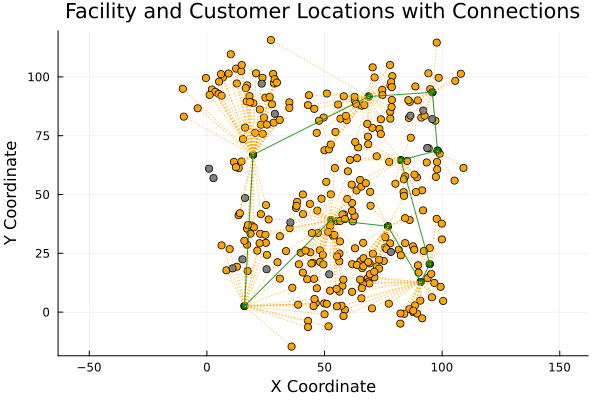

In [88]:
plot_facilities_and_customers(facility_coords, customer_coords, x, y, Z)

In [90]:
# Save `x` as a CSV
x_df = DataFrame(x = x)
CSV.write("x.csv", x_df)

# Save `y` as a CSV
y_df = DataFrame(y, :auto)  # Convert to DataFrame with auto-generated column names
CSV.write("y.csv", y_df)

# Save `z` as a CSV
z_df = DataFrame(Z, :auto)  # Convert to DataFrame with auto-generated column names
CSV.write("z.csv", z_df)

"z.csv"